In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
import pandas as pd
import numpy as np
from functools import reduce
from imblearn.over_sampling import RandomOverSampler

# Load Satellite Data

In [2]:
sites_data = pd.read_csv("~data/sites_data_11x11.csv")
sites_data

,time,lat,lon,TUR,SPM,CHL,site
0,2022-03-01,55.189352,-1.519043,NaN,NaN,NaN,Newbiggin_North
1,2022-03-01,55.189352,-1.517296,NaN,NaN,NaN,Newbiggin_North
2,2022-03-01,55.189352,-1.515549,NaN,NaN,NaN,Newbiggin_North
3,2022-03-01,55.189352,-1.513802,NaN,NaN,NaN,Newbiggin_North
4,2022-03-01,55.189352,-1.512055,NaN,NaN,NaN,Newbiggin_North
...,...,...,...,...,...,...,...
12331105,2022-10-31,50.277315,-3.893256,2.006134,1.186131,1.828091,Bigbury-on-Sea_South
12331106,2022-10-31,50.277315,-3.891509,0.708182,0.406647,1.046769,Bigbury-on-Sea_South
12331107,2022-10-31,50.277315,-3.889762,1.258156,0.729469,1.327342,Bigbury-on-Sea_South
12331108,2022-10-31,50.277315,-3.888015,1.037095,0.598882,1.254974,Bigbury-on-Sea_South


In [3]:
sites_data.isnull().sum()

time           0
lat            0
lon            0
TUR     10838900
SPM     10838900
CHL     10838900
site           0
dtype: int64

In [4]:
# Fill Null Values with 0, as we cannot have missing values in the tensors for neural network
# Later we will remove time, site pairs where all values are 0

sites_data.fillna(value=0, inplace=True)

# Load Pollution Data

In [52]:
riskforecasting = pd.read_csv('~data/pollution_risk_forecasting.csv')
riskforecasting

,Unnamed: 0,site,time,warning,riskLevelLabel
0,0,Seaton Carew North,2022-04-28,Pollution RIsk Forecasts will start soon,normal
1,1,Seaton Carew North,2022-04-29,Pollution RIsk Forecasts will start soon,normal
2,2,Seaton Carew North,2022-04-30,Pollution RIsk Forecasts will start soon,normal
3,3,Seaton Carew North,2022-05-04,No warnings in place,normal
4,4,Seaton Carew North,2022-05-05,No warnings in place,normal
...,...,...,...,...,...
63641,63641,Westward Ho!,2022-09-26,No pollution incidents reported,normal
63642,63642,Westward Ho!,2022-09-27,No pollution incidents reported,normal
63643,63643,Westward Ho!,2022-09-28,No pollution incidents reported,normal
63644,63644,Westward Ho!,2022-09-29,No pollution incidents reported,normal


In [53]:
riskforecasting[riskforecasting.duplicated(subset=['time', 'site'])]

,Unnamed: 0,site,time,warning,riskLevelLabel
7223,7223,Blackpool Central,2022-09-02,Risk of reduced water quality due to sewage,increased
7376,7376,Blackpool North,2022-09-02,Risk of reduced water quality due to sewage,increased
8872,8872,Southport,2022-08-16,Risk of reduced water quality due to animal waste,increased
8879,8879,Southport,2022-08-23,"Pollution incident ended, no forecast available",normal
13843,13843,Ingoldmells South,2022-07-31,Risk of reduced water quality due to sewage,increased
13845,13845,Ingoldmells South,2022-08-01,"Pollution incident ended, no forecast available",normal
13888,13888,Ingoldmells South,2022-09-14,Risk of reduced water quality due to harmful a...,increased
19814,19814,Brightlingsea,2022-05-13,Risk of reduced water quality due to sewage,increased
19815,19815,Brightlingsea,2022-05-13,"Pollution incident ended, no forecast available",normal
22628,22628,Bexhill,2022-08-17,Risk of reduced water quality due to sewage,increased


# Combine Datasets to Create Input Dataset
For every site (430) and time (237), create a 11 x 11 x 3 tensor, each corresponding to one risk level label 

In [6]:
%%time
def chl_to_array(chl_values):
    # Not 100% sure if this reshapes according to lat/lon (though it does not matter if we perform the same operation every time?)
    return np.array(chl_values).reshape(11, 11)

def get_features_data(sites_data, features_list):
    '''
    input: 
        - sites_data (pd.DataFrame):
            - dataframe where each row contains feature values for a time, site and coordinate
        - features_list (list):
            - list of strings of features to use
            
    output:
        - features data (pd.DataFrame)
            - row: data for every time and site pair
            - column: features
            - entries: np.array of shape 11x11
    '''
    dfs = []
    for feature in features_list:
        df = pd.DataFrame(sites_data.groupby(['time', 'site'])[feature].apply(chl_to_array))
        dfs.append(df)
    input_data = reduce(lambda  left,right: pd.merge(left,right,on=['time', 'site'],how='outer'), dfs)
    
    return input_data

features_df = get_features_data(sites_data, ['TUR', 'SPM', 'CHL'])
features_df

CPU times: user 5.87 s, sys: 770 ms, total: 6.64 s
Wall time: 7.07 s


TUR  \
time       site                                                                        
2022-03-01 Ainsdale                [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Allonby                 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Allonby_South           [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Amble_Links             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Anderby                 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                                              ...   
2022-10-31 Withernsea              [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Wolvercote_Mill_Stream  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Woolacombe_Village      [[5.9864016, 25.982555, 0.0, 0.0, 0.0, 0.0, 0....   
           Worthing                [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Yaverland               [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                                                 SPM  \
time       site                                                                        
2022-03-01 Ainsdale                [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Allonby                 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Allonby_South           [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Amble_Links             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Anderby                 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                                              ...   
2022-10-31 Withernsea              [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Wolvercote_Mill_Stream  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Woolacombe_Village      [[3.564524, 16.43204, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Worthing                [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
           Yaverland               [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                                                                 CHL  
time       site                                                                       
2022-03-01 Ainsdale                [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
           Allonby                 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
           Allonby_South           [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
           Amble_Links             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
           Anderby                 [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
...                                                                              ...  
2022-10-31 Withernsea              [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
           Wolvercote_Mill_Stream  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
           Woolacombe_Village      [[6.564089, 6.803925, 0.0, 0.0, 0.0, 0.0, 0.0,...  
           Worthing                [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
           Yaverland               [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  

[101910 rows x 3 columns]

In [7]:
# Naming inconsistencies

site_df = pd.read_csv("~data/site.csv")
site_df = site_df[['label', 'Site Name in Files']]
riskforecasting = riskforecasting.merge(site_df, left_on='site', right_on='label', how='left').drop(['label', 'warning'], axis=1)
riskforecasting

,Unnamed: 0,site,time,riskLevelLabel,Site Name in Files
0,0,Seaton Carew North,2022-04-28,normal,Seaton_Carew_North
1,1,Seaton Carew North,2022-04-29,normal,Seaton_Carew_North
2,2,Seaton Carew North,2022-04-30,normal,Seaton_Carew_North
3,3,Seaton Carew North,2022-05-04,normal,Seaton_Carew_North
4,4,Seaton Carew North,2022-05-05,normal,Seaton_Carew_North
...,...,...,...,...,...
63641,63641,Westward Ho!,2022-09-26,normal,Westward_Ho!
63642,63642,Westward Ho!,2022-09-27,normal,Westward_Ho!
63643,63643,Westward Ho!,2022-09-28,normal,Westward_Ho!
63644,63644,Westward Ho!,2022-09-29,normal,Westward_Ho!


In [8]:
# Merging datasets. Merge on riskforecasting (only add CHL values if we have riskLevellabel)
input_data = features_df.merge(riskforecasting, how='right', left_on=['time', 'site'], right_on=['time', 'Site Name in Files'])

In [9]:
# Missing data check. 
# Data missing for 07-23 and 07-25 for all sites - No satellite data

input_data[input_data['CHL'].isnull()]['time'].value_counts()

2022-07-23    421
2022-07-25    421
2022-02-08      2
2022-12-02      2
2022-02-25      2
2022-02-06      2
2022-11-07      1
2022-11-08      1
2022-11-03      1
2022-11-04      1
2022-01-09      1
2022-12-07      1
2022-12-08      1
2023-01-17      1
2022-12-19      1
2022-04-06      1
2022-02-09      1
2022-02-10      1
2022-02-19      1
2022-02-23      1
2022-01-17      1
Name: time, dtype: int64

In [10]:
# Other missing values to look into - why do we have risk level labels but not satellite data when merging? Naming issue?

input_data[(input_data['CHL'].isnull()) & (input_data['time'] != '2022-07-23') & (input_data['time'] != '2022-07-25')]

,time,TUR,SPM,CHL,Unnamed: 0,site,riskLevelLabel,Site Name in Files
13905,2022-12-19,NaN,NaN,NaN,13905,Ingoldmells South,normal,Ingoldmells_South
21307,2022-02-06,NaN,NaN,NaN,21307,Pevensey Bay,increased,Pevensey_Bay
21308,2022-02-08,NaN,NaN,NaN,21308,Pevensey Bay,normal,Pevensey_Bay
21460,2022-02-06,NaN,NaN,NaN,21460,Eastbourne,increased,Eastbourne
21461,2022-02-08,NaN,NaN,NaN,21461,Eastbourne,normal,Eastbourne
27204,2022-11-07,NaN,NaN,NaN,27204,Gurnard,increased,Gurnard
27205,2022-11-08,NaN,NaN,NaN,27205,Gurnard,normal,Gurnard
27804,2022-11-03,NaN,NaN,NaN,27804,Seagrove,increased,Seagrove
27805,2022-11-04,NaN,NaN,NaN,27805,Seagrove,normal,Seagrove
43071,2022-01-09,NaN,NaN,NaN,43071,Maenporth,increased,Maenporth


In [11]:
# Drop NA values for now as there are not that many of them
input_data.dropna(inplace=True)
input_data.shape

(62781, 8)

In [45]:
# Remove rows where everything is 0 (i.e. (basically) all missing values)
def has_nonzero(arr):
    return np.any(arr != 0)

input_data = input_data[input_data['CHL'].apply(has_nonzero)]
input_data

,time,TUR,SPM,CHL,Unnamed: 0,site,riskLevelLabel,Site Name in Files
1,2022-04-29,"[[0.0, 0.0, 0.0, 0.0, 6.66657, 17.572878, 10.8...","[[0.0, 0.0, 0.0, 0.0, 3.965849, 10.934258, 7.0...","[[0.0, 0.0, 0.0, 0.0, 3.342492, 8.107634, 9.17...",1,Seaton Carew North,normal,Seaton_Carew_North
3,2022-05-04,"[[0.0, 0.0, 0.0, 6.540016, 2.0652199, 5.831321...","[[0.0, 0.0, 0.0, 3.9651499, 1.2428378, 3.49029...","[[0.0, 0.0, 0.0, 4.6985893, 3.716854, 11.43752...",3,Seaton Carew North,normal,Seaton_Carew_North
13,2022-05-14,"[[0.0, 0.0, 0.0, 7.645644, 3.5351295, 5.733563...","[[0.0, 0.0, 0.0, 4.581397, 2.1685658, 3.419794...","[[0.0, 0.0, 0.0, 5.416618, 4.1310344, 14.67494...",13,Seaton Carew North,normal,Seaton_Carew_North
15,2022-05-16,"[[0.0, 0.0, 0.0, 7.8827524, 4.909162, 7.495511...","[[0.0, 0.0, 0.0, 4.6897936, 3.0189908, 4.60904...","[[0.0, 0.0, 0.0, 5.1706023, 4.0242176, 15.5288...",15,Seaton Carew North,increased,Seaton_Carew_North
18,2022-05-19,"[[0.0, 0.0, 0.0, 7.920317, 8.67042, 11.013622,...","[[0.0, 0.0, 0.0, 4.654839, 5.33716, 7.094655, ...","[[0.0, 0.0, 0.0, 4.5101485, 3.6868532, 15.4022...",18,Seaton Carew North,normal,Seaton_Carew_North
...,...,...,...,...,...,...,...,...
63634,2022-09-19,"[[7.055306, 11.538847, 21.925156, 38.97817, 67...","[[4.1807566, 6.9168806, 13.601273, 25.838427, ...","[[9.039883, 9.1092415, 8.58365, 8.242571, 1.83...",63634,Westward Ho!,normal,Westward_Ho!
63636,2022-09-21,"[[7.0546794, 11.46094, 21.594828, 37.921295, 6...","[[4.1956024, 6.904963, 13.490634, 25.326557, 4...","[[9.529826, 9.603931, 8.9767, 8.631461, 1.8302...",63636,Westward Ho!,normal,Westward_Ho!
63639,2022-09-24,"[[8.833501, 13.690014, 24.412632, 37.04687, 77...","[[5.320448, 8.367022, 15.584268, 24.799337, 58...","[[11.152357, 11.245967, 10.390406, 9.975812, 1...",63639,Westward Ho!,normal,Westward_Ho!
63641,2022-09-26,"[[12.430533, 17.521309, 27.909481, 32.5058, 90...","[[7.6267166, 10.912169, 18.30988, 21.522917, 6...","[[11.114327, 11.215534, 10.675369, 10.119238, ...",63641,Westward Ho!,normal,Westward_Ho!


In [48]:
input_data[input_data.duplicated(subset=['time','site'])]

,time,TUR,SPM,CHL,Unnamed: 0,site,riskLevelLabel,Site Name in Files
13845,2022-08-01,"[[0.0, 0.0, 0.0, 0.0, 0.0, 53.309795, 40.84926...","[[0.0, 0.0, 0.0, 0.0, 0.0, 35.42404, 26.986582...","[[0.0, 0.0, 0.0, 0.0, 0.0, 9.0707655, 8.717103...",13845,Ingoldmells South,normal,Ingoldmells_South
19814,2022-05-13,"[[50.716316, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[32.724876, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[9.654404, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",19814,Brightlingsea,increased,Brightlingsea
19815,2022-05-13,"[[50.716316, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[32.724876, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[9.654404, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",19815,Brightlingsea,normal,Brightlingsea
29126,2022-08-19,"[[4.6069183, 4.710744, 5.053973, 6.166085, 7.2...","[[2.7126315, 2.764591, 2.9779804, 3.669368, 4....","[[5.933363, 5.529211, 5.7127233, 6.2821183, 6....",29126,Tankerton,increased,Tankerton
29127,2022-08-19,"[[4.6069183, 4.710744, 5.053973, 6.166085, 7.2...","[[2.7126315, 2.764591, 2.9779804, 3.669368, 4....","[[5.933363, 5.529211, 5.7127233, 6.2821183, 6....",29127,Tankerton,increased,Tankerton
29281,2022-08-19,"[[6.598432, 6.607899, 9.173917, 7.53592, 6.183...","[[3.9266617, 3.9367855, 5.5377145, 4.4927335, ...","[[9.5883255, 9.15639, 9.120165, 9.668127, 9.81...",29281,Herne Bay Central,increased,Herne_Bay_Central
29282,2022-08-19,"[[6.598432, 6.607899, 9.173917, 7.53592, 6.183...","[[3.9266617, 3.9367855, 5.5377145, 4.4927335, ...","[[9.5883255, 9.15639, 9.120165, 9.668127, 9.81...",29282,Herne Bay Central,increased,Herne_Bay_Central
29283,2022-08-19,"[[6.598432, 6.607899, 9.173917, 7.53592, 6.183...","[[3.9266617, 3.9367855, 5.5377145, 4.4927335, ...","[[9.5883255, 9.15639, 9.120165, 9.668127, 9.81...",29283,Herne Bay Central,normal,Herne_Bay_Central
29284,2022-08-19,"[[6.598432, 6.607899, 9.173917, 7.53592, 6.183...","[[3.9266617, 3.9367855, 5.5377145, 4.4927335, ...","[[9.5883255, 9.15639, 9.120165, 9.668127, 9.81...",29284,Herne Bay Central,increased,Herne_Bay_Central
44565,2022-09-11,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",44565,Coverack,normal,Coverack


In [46]:
input_data.drop_duplicates(subset=['time','site'])

,time,TUR,SPM,CHL,Unnamed: 0,site,riskLevelLabel,Site Name in Files
1,2022-04-29,"[[0.0, 0.0, 0.0, 0.0, 6.66657, 17.572878, 10.8...","[[0.0, 0.0, 0.0, 0.0, 3.965849, 10.934258, 7.0...","[[0.0, 0.0, 0.0, 0.0, 3.342492, 8.107634, 9.17...",1,Seaton Carew North,normal,Seaton_Carew_North
3,2022-05-04,"[[0.0, 0.0, 0.0, 6.540016, 2.0652199, 5.831321...","[[0.0, 0.0, 0.0, 3.9651499, 1.2428378, 3.49029...","[[0.0, 0.0, 0.0, 4.6985893, 3.716854, 11.43752...",3,Seaton Carew North,normal,Seaton_Carew_North
13,2022-05-14,"[[0.0, 0.0, 0.0, 7.645644, 3.5351295, 5.733563...","[[0.0, 0.0, 0.0, 4.581397, 2.1685658, 3.419794...","[[0.0, 0.0, 0.0, 5.416618, 4.1310344, 14.67494...",13,Seaton Carew North,normal,Seaton_Carew_North
15,2022-05-16,"[[0.0, 0.0, 0.0, 7.8827524, 4.909162, 7.495511...","[[0.0, 0.0, 0.0, 4.6897936, 3.0189908, 4.60904...","[[0.0, 0.0, 0.0, 5.1706023, 4.0242176, 15.5288...",15,Seaton Carew North,increased,Seaton_Carew_North
18,2022-05-19,"[[0.0, 0.0, 0.0, 7.920317, 8.67042, 11.013622,...","[[0.0, 0.0, 0.0, 4.654839, 5.33716, 7.094655, ...","[[0.0, 0.0, 0.0, 4.5101485, 3.6868532, 15.4022...",18,Seaton Carew North,normal,Seaton_Carew_North
...,...,...,...,...,...,...,...,...
63634,2022-09-19,"[[7.055306, 11.538847, 21.925156, 38.97817, 67...","[[4.1807566, 6.9168806, 13.601273, 25.838427, ...","[[9.039883, 9.1092415, 8.58365, 8.242571, 1.83...",63634,Westward Ho!,normal,Westward_Ho!
63636,2022-09-21,"[[7.0546794, 11.46094, 21.594828, 37.921295, 6...","[[4.1956024, 6.904963, 13.490634, 25.326557, 4...","[[9.529826, 9.603931, 8.9767, 8.631461, 1.8302...",63636,Westward Ho!,normal,Westward_Ho!
63639,2022-09-24,"[[8.833501, 13.690014, 24.412632, 37.04687, 77...","[[5.320448, 8.367022, 15.584268, 24.799337, 58...","[[11.152357, 11.245967, 10.390406, 9.975812, 1...",63639,Westward Ho!,normal,Westward_Ho!
63641,2022-09-26,"[[12.430533, 17.521309, 27.909481, 32.5058, 90...","[[7.6267166, 10.912169, 18.30988, 21.522917, 6...","[[11.114327, 11.215534, 10.675369, 10.119238, ...",63641,Westward Ho!,normal,Westward_Ho!


# From Dataset to Tensor

In [39]:
time_site_pairs = input_data[['time', 'site']]

# 80/20 split
time_site_pairs_test = time_site_pairs.sample(frac=.2, random_state=42)
# time_site_pairs_test = time_site_pairs_test.rename(columns={'Site Name in Files': 'site'})
time_site_pairs_test

,time,site
30146,2022-07-05,Sandgate
23187,2022-07-02,Shoreham Beach
44377,2022-08-05,Porthoustock
46583,2022-05-29,Harlyn Bay
3387,2022-07-03,Druridge Bay South
...,...,...
48917,2022-08-02,Wherry Town
23074,2022-08-09,Southwick
9803,2022-09-11,"Danes Dyke, Flamborough"
51359,2022-08-25,Par Sands


In [40]:
time_site_pairs_train = time_site_pairs[~time_site_pairs.isin(time_site_pairs_test)].dropna()
time_site_pairs_train

,time,site
3,2022-05-04,Seaton Carew North
13,2022-05-14,Seaton Carew North
18,2022-05-19,Seaton Carew North
23,2022-05-24,Seaton Carew North
28,2022-05-29,Seaton Carew North
...,...,...
63626,2022-09-11,Westward Ho!
63629,2022-09-14,Westward Ho!
63631,2022-09-16,Westward Ho!
63639,2022-09-24,Westward Ho!


In [54]:
input_data_1 = input_data.drop_duplicates(subset=['time','site'])
input_data_1

,time,TUR,SPM,CHL,Unnamed: 0,site,riskLevelLabel,Site Name in Files
1,2022-04-29,"[[0.0, 0.0, 0.0, 0.0, 6.66657, 17.572878, 10.8...","[[0.0, 0.0, 0.0, 0.0, 3.965849, 10.934258, 7.0...","[[0.0, 0.0, 0.0, 0.0, 3.342492, 8.107634, 9.17...",1,Seaton Carew North,normal,Seaton_Carew_North
3,2022-05-04,"[[0.0, 0.0, 0.0, 6.540016, 2.0652199, 5.831321...","[[0.0, 0.0, 0.0, 3.9651499, 1.2428378, 3.49029...","[[0.0, 0.0, 0.0, 4.6985893, 3.716854, 11.43752...",3,Seaton Carew North,normal,Seaton_Carew_North
13,2022-05-14,"[[0.0, 0.0, 0.0, 7.645644, 3.5351295, 5.733563...","[[0.0, 0.0, 0.0, 4.581397, 2.1685658, 3.419794...","[[0.0, 0.0, 0.0, 5.416618, 4.1310344, 14.67494...",13,Seaton Carew North,normal,Seaton_Carew_North
15,2022-05-16,"[[0.0, 0.0, 0.0, 7.8827524, 4.909162, 7.495511...","[[0.0, 0.0, 0.0, 4.6897936, 3.0189908, 4.60904...","[[0.0, 0.0, 0.0, 5.1706023, 4.0242176, 15.5288...",15,Seaton Carew North,increased,Seaton_Carew_North
18,2022-05-19,"[[0.0, 0.0, 0.0, 7.920317, 8.67042, 11.013622,...","[[0.0, 0.0, 0.0, 4.654839, 5.33716, 7.094655, ...","[[0.0, 0.0, 0.0, 4.5101485, 3.6868532, 15.4022...",18,Seaton Carew North,normal,Seaton_Carew_North
...,...,...,...,...,...,...,...,...
63634,2022-09-19,"[[7.055306, 11.538847, 21.925156, 38.97817, 67...","[[4.1807566, 6.9168806, 13.601273, 25.838427, ...","[[9.039883, 9.1092415, 8.58365, 8.242571, 1.83...",63634,Westward Ho!,normal,Westward_Ho!
63636,2022-09-21,"[[7.0546794, 11.46094, 21.594828, 37.921295, 6...","[[4.1956024, 6.904963, 13.490634, 25.326557, 4...","[[9.529826, 9.603931, 8.9767, 8.631461, 1.8302...",63636,Westward Ho!,normal,Westward_Ho!
63639,2022-09-24,"[[8.833501, 13.690014, 24.412632, 37.04687, 77...","[[5.320448, 8.367022, 15.584268, 24.799337, 58...","[[11.152357, 11.245967, 10.390406, 9.975812, 1...",63639,Westward Ho!,normal,Westward_Ho!
63641,2022-09-26,"[[12.430533, 17.521309, 27.909481, 32.5058, 90...","[[7.6267166, 10.912169, 18.30988, 21.522917, 6...","[[11.114327, 11.215534, 10.675369, 10.119238, ...",63641,Westward Ho!,normal,Westward_Ho!


In [55]:
pd.merge(time_site_pairs_test, input_data_1, on=['time', 'site'])

,time,site,TUR,SPM,CHL,Unnamed: 0,riskLevelLabel,Site Name in Files
0,2022-07-05,Sandgate,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",30146,normal,Sandgate
1,2022-07-02,Shoreham Beach,"[[0.0, 12.960671, 8.550011, 9.289367, 11.89932...","[[0.0, 7.8188233, 5.0709224, 5.538015, 7.11776...","[[0.0, 8.588664, 8.075708, 6.362367, 11.854029...",23187,normal,Shoreham_Beach
2,2022-08-05,Porthoustock,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7336731...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4309942...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0510032...",44377,normal,Porthoustock
3,2022-05-29,Harlyn Bay,"[[0.0, 0.0, 3.1721117, 1.5252931, 1.2357141, 1...","[[0.0, 0.0, 1.866343, 0.8916788, 0.72191876, 0...","[[0.0, 0.0, 2.337979, 1.3655915, 1.1565907, 0....",46583,normal,Harlyn_Bay
4,2022-07-03,Druridge Bay South,"[[0.0, 15.714755, 22.783144, 4.104411, 3.02127...","[[0.0, 9.981267, 16.599281, 2.4052901, 1.76544...","[[0.0, 6.7885923, 3.629534, 3.390229, 2.001242...",3387,normal,Druridge_Bay_South
...,...,...,...,...,...,...,...,...
3550,2022-08-02,Wherry Town,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",48917,normal,Wherry_Town
3551,2022-08-09,Southwick,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",23074,normal,Southwick
3552,2022-09-11,"Danes Dyke, Flamborough","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9803,normal,"Danes_Dyke,_Flamborough"
3553,2022-08-25,Par Sands,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",51359,normal,Par_Sands


In [42]:
pd.merge(time_site_pairs_train, input_data, on=['time', 'site'])

,time,site,TUR,SPM,CHL,Unnamed: 0,riskLevelLabel,Site Name in Files
0,2022-05-04,Seaton Carew North,"[[0.0, 0.0, 0.0, 6.540016, 2.0652199, 5.831321...","[[0.0, 0.0, 0.0, 3.9651499, 1.2428378, 3.49029...","[[0.0, 0.0, 0.0, 4.6985893, 3.716854, 11.43752...",3,normal,Seaton_Carew_North
1,2022-05-14,Seaton Carew North,"[[0.0, 0.0, 0.0, 7.645644, 3.5351295, 5.733563...","[[0.0, 0.0, 0.0, 4.581397, 2.1685658, 3.419794...","[[0.0, 0.0, 0.0, 5.416618, 4.1310344, 14.67494...",13,normal,Seaton_Carew_North
2,2022-05-19,Seaton Carew North,"[[0.0, 0.0, 0.0, 7.920317, 8.67042, 11.013622,...","[[0.0, 0.0, 0.0, 4.654839, 5.33716, 7.094655, ...","[[0.0, 0.0, 0.0, 4.5101485, 3.6868532, 15.4022...",18,normal,Seaton_Carew_North
3,2022-05-24,Seaton Carew North,"[[0.0, 0.0, 0.0, 7.6612864, 10.168264, 7.91841...","[[0.0, 0.0, 0.0, 4.5182247, 6.248814, 4.939714...","[[0.0, 0.0, 0.0, 4.1892023, 3.4925961, 13.6939...",23,normal,Seaton_Carew_North
4,2022-05-29,Seaton Carew North,"[[0.0, 0.0, 0.0, 7.668683, 10.982789, 7.10224,...","[[0.0, 0.0, 0.0, 4.5195827, 6.6928806, 4.36403...","[[0.0, 0.0, 0.0, 4.014257, 3.3749583, 12.17790...",28,normal,Seaton_Carew_North
...,...,...,...,...,...,...,...,...
14262,2022-09-11,Westward Ho!,"[[7.083355, 11.683977, 22.441946, 40.487473, 7...","[[4.194306, 7.014123, 13.980078, 27.119347, 51...","[[9.154786, 9.218182, 8.400933, 8.180671, 1.83...",63626,normal,Westward_Ho!
14263,2022-09-14,Westward Ho!,"[[8.244977, 13.170067, 24.363747, 39.806564, 7...","[[4.899443, 7.9151998, 15.199246, 26.204464, 5...","[[8.420948, 8.484287, 8.078481, 7.7452517, 1.8...",63629,normal,Westward_Ho!
14264,2022-09-16,Westward Ho!,"[[8.792884, 13.990583, 25.785875, 41.127502, 8...","[[5.2243996, 8.392741, 16.04207, 26.810604, 61...","[[7.919096, 7.98147, 7.821743, 7.424859, 1.830...",63631,normal,Westward_Ho!
14265,2022-09-24,Westward Ho!,"[[8.833501, 13.690014, 24.412632, 37.04687, 77...","[[5.320448, 8.367022, 15.584268, 24.799337, 58...","[[11.152357, 11.245967, 10.390406, 9.975812, 1...",63639,normal,Westward_Ho!


In [79]:
def get_train_test_val_nn(input_data, train_labels, test_labels, oversampling = True, desired_pos_ratio =  0.5, train_val_ratio = 0.8):
    '''
        input: 
        - input_data (pd.DataFrame): 
            - dataframe of shape (m, n)
            - number of datapoints = m
            - features to consider = n-1
            - one of the columns = 'riskLevelLabel'
            
        - train_labels (pd.DataFrame):
            - dataframe with two columns 'time' and 'site'
            - time and site pairs for train data
        
        - test_labels (pd.DataFrame)
            - dataframe with two columns 'time' and 'site'
            - time and site pairs for test data
            
        - oversampling (Boolean):
            - Whether oversampling should be performed

        - desired_pos_ratio (float):
            - desired ratio of positive samples when performing random oversampling

        - train_val_ratio (float):
            - ratio of training data to validation data
            
    output:
        - X_train (tensor)
        - X_test (tensor)
        - X_val (tensor)
        - y_train (np.array)
        - y_test (np.array)
        - y_val (np.array)
    '''
    train = pd.merge(train_labels, input_data, on=['time', 'site'])
    test = pd.merge(test_labels, input_data, on=['time', 'site'])
    
    # Getting X and y
    features_column_names = list(input_data.columns)
    for x in ['riskLevelLabel', 'time', 'site']:
        features_column_names.remove(x)
        
    X_train, X_test = train[features_column_names], test[features_column_names]
    y_train = np.array([1 if x == 'increased' else 0 for x in train['riskLevelLabel']])
    y_test = np.array([1 if x == 'increased' else 0 for x in test['riskLevelLabel']])
    
    # Oversampling for training data
    if oversampling:
        
        # Counting number of samples to oversample
        num_positives, num_negatives = sum(y_train), len(y_train)-sum(y_train)
        num_positives_to_repeat = int(desired_pos_ratio * num_negatives * 2) - num_positives
        
        # Oversampling
        ros = RandomOverSampler(sampling_strategy={1: num_positives_to_repeat}, random_state=42)
        X_train, y_train = ros.fit_resample(X_train, y_train)
        
    # Reshape and Convert to Tensor
    # X_train
    if X_train.shape[1] == 1: 
        X_train = np.array([i for i in X_train[features_column_names[0]]])
        X_train = tf.convert_to_tensor(X_train)
        X_train = tf.expand_dims(X_train, axis=3, name=None)
    else:
        X_train = np.stack([np.stack(X_train[col].values) for col in X_train.columns], axis=1)
        X_train = np.transpose(X_train, (0, 2, 3, 1))
        X_train = tf.convert_to_tensor(X_train)
        
    # X_test
    if X_test.shape[1] == 1: 
        X_test = np.array([i for i in X_test[features_column_names[0]]])
        X_test = tf.convert_to_tensor(X_test)
        X_test = tf.expand_dims(X_test, axis=3, name=None)
    else:
        X_test = np.stack([np.stack(X_test[col].values) for col in X_test.columns], axis=1)
        X_test = np.transpose(X_test, (0, 2, 3, 1))
        X_test = tf.convert_to_tensor(X_test)
        
    X_train = tf.pad(X_train, [[0, 0], [11,10], [11,10], [0,0]])
    X_test = tf.pad(X_test, [[0, 0], [11,10], [11,10], [0,0]])
    
    # Train Validation Split
    i = int(X_train.shape[0] * train_val_ratio)
    X_val, y_val = X_train[i:], y_train[i:]
    X_train, y_train = X_train[:i], y_train[:i]
    
    return X_train, X_test, X_val, y_train, y_test, y_val    

In [170]:
# Custom F1 Score

from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [173]:
def fit_nn(X_train, X_test, X_val, y_train, y_test, y_val, model_type, metrics=['acc','AUC','Precision','Recall', f1], loss='binary_crossentropy', optimizer='adam'):
    '''
    model_type: "baseline"/"convolution" (string)
    loss: "binary_crossentropy" (string)
    metrics: list of metrics to track. available metrics are: (list of string)
        - "acc"
        - "AUC"
        - "Precision"
        - "Recall"
        - f1
    '''
    model = models.Sequential()
    
    if model_type == "baseline":
        model.add(layers.Flatten(input_shape=X_train.shape[1:]))
        model.add(layers.Dense(100, activation='relu'))
        model.add(layers.Dense(1, activation="sigmoid"))
        
    elif model_type == "convolution":
        model.add(layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=X_train.shape[1:]))
        model.add(layers.AveragePooling2D(pool_size=2, strides=2))
        model.add(layers.Conv2D(filters=16, kernel_size=5, activation='relu'))
        model.add(layers.AveragePooling2D(pool_size=2, strides=2))
        model.add(layers.Flatten())
        model.add(layers.Dense(120, activation='relu')),
        model.add(layers.Dense(84, activation='relu')),
        model.add(layers.Dense(10, activation='relu')),
        model.add(layers.Dense(1, activation='sigmoid'))

    else:
        print('Model Type Undefined')
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    # Fit Model
    history = model.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate Model
    result = model.evaluate(X_test, y_test)
    
    return history, result

In [175]:
%%time
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val_nn(input_data_, 
                                                                       time_site_pairs_train, 
                                                                       time_site_pairs_test, 
                                                                       oversampling = False)

history, result = fit_nn(X_train, X_test, X_val, y_train, y_test, y_val, "baseline")


112/112 [==============================] - 0s 603us/step - loss: 0.0926 - acc: 0.9795 - auc: 0.8179 - precision: 0.5455 - recall: 0.0811 - f1: 0.0372         
CPU times: user 12.3 s, sys: 2.91 s, total: 15.2 s
Wall time: 8.78 s


In [69]:
# def get_train_test_val(input_data, desired_pos_ratio =  0.5, train_test_ratio = 0.8, train_val_ratio = 0.8):
#     '''
#     input: 
#         - input_data (pd.DataFrame): 
#             - dataframe of shape (m, n)
#             - number of datapoints = m
#             - features to consider = n-1
#             - one of the columns = 'riskLevelLabel'

#         - desired_pos_ratio (float):
#             - desired ratio of positive samples when performing random oversampling

#         - train_test_ratio (float):
#             - ratio of training data to testing data

#         - train_val_ratio (float):
#             - ratio of training data to validation data
            
#     output:
#         - X_train (tensor)
#         - X_test (tensor)
#         - X_val (tensor)
#         - y_train (np.array)
#         - y_test (np.array)
#         - y_val (np.array)
    
#     '''
    
#     # Getting X and y
#     features_column_names = list(input_data.columns)
#     features_column_names.remove('riskLevelLabel')
#     X = input_data[features_column_names]
#     y = np.array([1 if x == 'increased' else 0 for x in input_data['riskLevelLabel']])
    
#     # Counting number of samples to oversample
#     num_positives, num_negatives = sum(y), len(y)-sum(y)
#     num_positives_to_repeat = int(desired_pos_ratio * num_negatives * 2) - num_positives
    
#     # Oversampling
#     ros = RandomOverSampler(sampling_strategy={1: num_positives_to_repeat}, random_state=42)
#     X, y = ros.fit_resample(X, y)
    
#     # Reshape and Convert to Tensor
#     if X.shape[1] == 1: 
#         X = np.array([i for i in X[features_column_names[0]]])
#         X = tf.convert_to_tensor(X)
#         X = tf.expand_dims(X, axis=3, name=None)
#     else:
#         X = np.stack([np.stack(X[col].values) for col in X.columns], axis=1)
#         X = np.transpose(X, (0, 2, 3, 1))
#         X = tf.convert_to_tensor(X)
    
#     # Reshape to 32x32 with simple padding for model input
#     X = tf.pad(X, [[0, 0], [11,10], [11,10], [0,0]])
    
#     # Train Test Split
#     i = int(X.shape[0] * train_test_ratio)
#     X_train, y_train = X[:i], y[:i]
#     X_test, y_test = X[i:], y[i:]

#     # Train Validation Split
#     i = int(X.shape[0] * train_test_ratio * train_val_ratio)
#     X_val, y_val = X_train[i:], y_train[i:]
#     X_train, y_train = X_train[:i], y_train[:i]

#     return X_train, X_test, X_val, y_train, y_test, y_val

In [70]:
X = input_data[['CHL']]
X.columns[0]
# X = np.array([i for i in X])
# X = tf.convert_to_tensor(X)
# X = tf.expand_dims(X, axis=3, name=None)

'CHL'

In [15]:
X = input_data[['CHL']]
np.array([i for i in X['CHL']]).shape

(17777, 11, 11)

# Model Architecture

## Baseline (No Convolution)

In [147]:
model_b = models.Sequential()
model_b.add(layers.Flatten(input_shape=X_train.shape[1:]))
model_b.add(layers.Dense(100, activation='relu'))
model_b.add(layers.Dense(1, activation="sigmoid"))

# model_b.add(layers.AveragePooling2D(pool_size=2, strides=2, input_shape=X_train.shape[1:]))
# model_b.add(layers.Flatten())
# model_b.add(layers.Dense(120, activation='relu')),
# model_b.add(layers.Dense(84, activation='relu')),
# model_b.add(layers.Dense(10, activation='relu')),
# model_b.add(layers.Dense(1, activation='sigmoid'))

model_b.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 1024)              0         
                                                                 
 dense_32 (Dense)            (None, 100)               102500    
                                                                 
 dense_33 (Dense)            (None, 1)                 101       
                                                                 
Total params: 102,601
Trainable params: 102,601
Non-trainable params: 0
_________________________________________________________________


In [166]:
model_b.compile(optimizer=opt, loss='binary_crossentropy', metrics=["AUC"])

## Convolution

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=X_train.shape[1:]))
model.add(layers.AveragePooling2D(pool_size=2, strides=2))
model.add(layers.Conv2D(filters=16, kernel_size=5, activation='relu'))
model.add(layers.AveragePooling2D(pool_size=2, strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='relu')),
model.add(layers.Dense(84, activation='relu')),
model.add(layers.Dense(10, activation='relu')),
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

In [ ]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["acc"])

# Training and Results

## Plotting Function

In [138]:
def plot_train_val_loss(his, metric):
    '''
    input:
        - history
        - metric (acc/f1)
    output: 2 graphs
    '''
    fig, axs = plt.subplots(2, 1, figsize=(10,10))
    axs[0].plot(his.history['loss'])
    axs[0].plot(his.history['val_loss'])
    axs[0].title.set_text('Training Loss vs Validation Loss')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend(['Training', 'Validation'])
    axs[1].plot(his.history[f'{metric}'])
    axs[1].plot(his.history[f'val_{metric}'])
    axs[1].title.set_text(f'Training {metric} vs Validation {metric}')
    axs[1].legend(['Training', 'Validation'])
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel(f"{metric}")

## Defining F1 Metric

In [134]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Baseline, 1 feature (CHL)

### Data

In [124]:
input_data_ = input_data_1.drop(['Unnamed: 0', 'Site Name in Files'], axis=1)
input_data_ = input_data_[['CHL', 'riskLevelLabel', 'site', 'time']]

In [125]:
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val_nn(input_data_, time_site_pairs_train, time_site_pairs_test)

In [157]:
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val_nn(input_data_, time_site_pairs_train, time_site_pairs_test, oversampling = False)

In [158]:
X_train.shape

TensorShape([11377, 32, 32, 1])

### Model

In [161]:
model_b = models.Sequential()
model_b.add(layers.AveragePooling2D(pool_size=2, strides=2, input_shape=X_train.shape[1:]))
model_b.add(layers.Flatten())
model_b.add(layers.Dense(120, activation='relu')),
model_b.add(layers.Dense(84, activation='relu')),
model_b.add(layers.Dense(10, activation='relu')),
model_b.add(layers.Dense(1, activation='sigmoid'))

model_b.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d_11 (Avera  (None, 16, 16, 1)        0         
 gePooling2D)                                                    
                                                                 
 flatten_14 (Flatten)        (None, 256)               0         
                                                                 
 dense_44 (Dense)            (None, 120)               30840     
                                                                 
 dense_45 (Dense)            (None, 84)                10164     
                                                                 
 dense_46 (Dense)            (None, 10)                850       
                                                                 
 dense_47 (Dense)            (None, 1)                 11        
                                                     

In [167]:
opt = 'adam'
# model_b.compile(optimizer=opt, loss='binary_crossentropy', metrics=["acc"])
model_b.compile(optimizer=opt, loss='binary_crossentropy', metrics=["AUC"])

In [168]:
history_b = model_b.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
178/178 [==============================] - 1s 2ms/step - loss: 0.0654 - auc: 0.9326 - val_loss: 0.2234 - val_auc: 0.5110
Epoch 2/40
178/178 [==============================] - 0s 1ms/step - loss: 0.0626 - auc: 0.9431 - val_loss: 0.2033 - val_auc: 0.5143
Epoch 3/40
178/178 [==============================] - 0s 2ms/step - loss: 0.0641 - auc: 0.9414 - val_loss: 0.2135 - val_auc: 0.5155
Epoch 4/40
178/178 [==============================] - 0s 1ms/step - loss: 0.0626 - auc: 0.9439 - val_loss: 0.2110 - val_auc: 0.5367
Epoch 5/40
178/178 [==============================] - 0s 1ms/step - loss: 0.0629 - auc: 0.9411 - val_loss: 0.2064 - val_auc: 0.5260
Epoch 6/40
178/178 [==============================] - 0s 1ms/step - loss: 0.0617 - auc: 0.9457 - val_loss: 0.1949 - val_auc: 0.5565
Epoch 7/40
178/178 [==============================] - 0s 1ms/step - loss: 0.0610 - auc: 0.9535 - val_loss: 0.2115 - val_auc: 0.5323
Epoch 8/40
178/178 [==============================] - 0s 1ms/step - loss: 0.

In [164]:
history_b.history['f1']

[0.0,
 0.0,
 0.0,
 0.007490635383874178,
 0.024344565346837044,
 0.026217224076390266,
 0.014981270767748356,
 0.04138576611876488,
 0.024344567209482193,
 0.036142315715551376,
 0.03651684895157814,
 0.039807382971048355,
 0.06573033332824707,
 0.05599250644445419,
 0.05617976933717728,
 0.09026216715574265,
 0.06348314136266708,
 0.07153557986021042,
 0.10430710017681122,
 0.08071160316467285,
 0.09868913143873215,
 0.08623595535755157,
 0.0859818160533905,
 0.10099873691797256,
 0.0938202291727066,
 0.10639379173517227,
 0.09681648015975952,
 0.09082396328449249,
 0.1092696562409401,
 0.11123596131801605,
 0.09737826883792877,
 0.09438201785087585,
 0.10945692658424377,
 0.09272338449954987,
 0.09400749206542969,
 0.11382362246513367,
 0.1308988630771637,
 0.1086142286658287,
 0.1213482916355133,
 0.14063668251037598]

KeyError: 'f1'

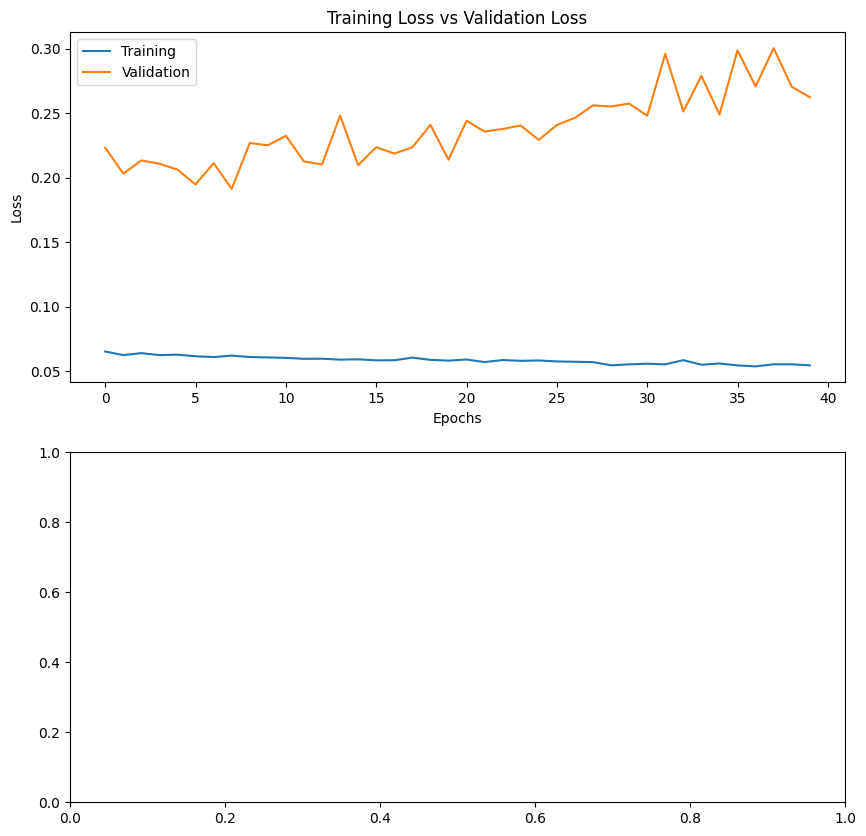

In [169]:
plot_train_val_loss(history_b, 'f1')

In [145]:
result_b_1 = model_b.evaluate(X_test, y_test)
result_b_1

112/112 [==============================] - 0s 534us/step - loss: 0.2562 - f1: 0.2031


[0.25621452927589417, 0.2030753791332245]

## Convolution, 1 feature (CHL)

### Model

In [103]:
model = models.Sequential()
model.add(layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=X_train.shape[1:]))
model.add(layers.AveragePooling2D(pool_size=2, strides=2))
model.add(layers.Conv2D(filters=16, kernel_size=5, activation='relu'))
model.add(layers.AveragePooling2D(pool_size=2, strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='relu')),
model.add(layers.Dense(84, activation='relu')),
model.add(layers.Dense(10, activation='relu')),
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 6)         156       
                                                                 
 average_pooling2d_5 (Averag  (None, 16, 16, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_6 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_4 (Flatten)         (None, 576)               0         
                                                                 
 dense_16 (Dense)            (None, 120)              

In [104]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["acc"])

In [105]:
history = model.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
344/344 [==============================] - 3s 9ms/step - loss: 0.5327 - acc: 0.7361 - val_loss: 0.6076 - val_acc: 0.6795
Epoch 2/40
344/344 [==============================] - 3s 8ms/step - loss: 0.3603 - acc: 0.8390 - val_loss: 0.3896 - val_acc: 0.8570
Epoch 3/40
344/344 [==============================] - 3s 9ms/step - loss: 0.2758 - acc: 0.8836 - val_loss: 0.4966 - val_acc: 0.7585
Epoch 4/40
344/344 [==============================] - 3s 9ms/step - loss: 0.2297 - acc: 0.9058 - val_loss: 0.2087 - val_acc: 0.9598
Epoch 5/40
344/344 [==============================] - 3s 9ms/step - loss: 0.2035 - acc: 0.9199 - val_loss: 0.2254 - val_acc: 0.9458
Epoch 6/40
344/344 [==============================] - 3s 9ms/step - loss: 0.1902 - acc: 0.9246 - val_loss: 0.1528 - val_acc: 0.9800
Epoch 7/40
344/344 [==============================] - 3s 9ms/step - loss: 0.1771 - acc: 0.9310 - val_loss: 0.1928 - val_acc: 0.9622
Epoch 8/40
344/344 [==============================] - 3s 9ms/step - loss: 0.

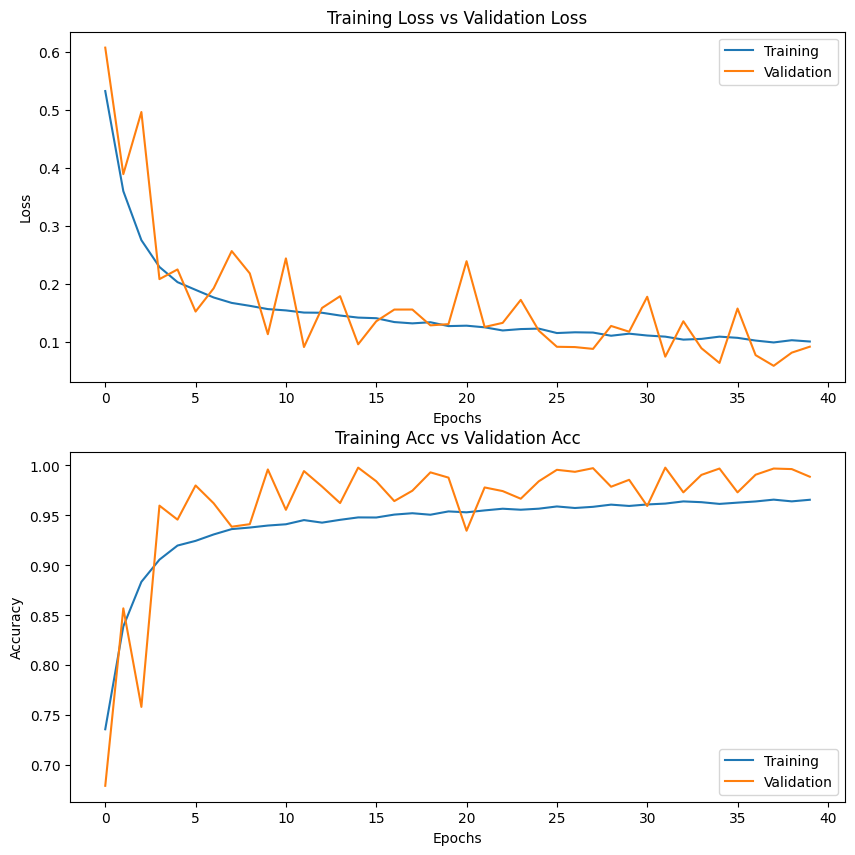

In [106]:
plot_train_val_loss_acc(history)

In [107]:
result_c_1 = model.evaluate(X_test, y_test)
result_c_1

112/112 [==============================] - 0s 2ms/step - loss: 0.2222 - acc: 0.9440


[0.2222413271665573, 0.9440224766731262]

## Baseline, 3 features

### Data

In [108]:
input_data_ = input_data_1.drop(['Unnamed: 0', 'Site Name in Files'], axis=1)
input_data_

,time,TUR,SPM,CHL,site,riskLevelLabel
1,2022-04-29,"[[0.0, 0.0, 0.0, 0.0, 6.66657, 17.572878, 10.8...","[[0.0, 0.0, 0.0, 0.0, 3.965849, 10.934258, 7.0...","[[0.0, 0.0, 0.0, 0.0, 3.342492, 8.107634, 9.17...",Seaton Carew North,normal
3,2022-05-04,"[[0.0, 0.0, 0.0, 6.540016, 2.0652199, 5.831321...","[[0.0, 0.0, 0.0, 3.9651499, 1.2428378, 3.49029...","[[0.0, 0.0, 0.0, 4.6985893, 3.716854, 11.43752...",Seaton Carew North,normal
13,2022-05-14,"[[0.0, 0.0, 0.0, 7.645644, 3.5351295, 5.733563...","[[0.0, 0.0, 0.0, 4.581397, 2.1685658, 3.419794...","[[0.0, 0.0, 0.0, 5.416618, 4.1310344, 14.67494...",Seaton Carew North,normal
15,2022-05-16,"[[0.0, 0.0, 0.0, 7.8827524, 4.909162, 7.495511...","[[0.0, 0.0, 0.0, 4.6897936, 3.0189908, 4.60904...","[[0.0, 0.0, 0.0, 5.1706023, 4.0242176, 15.5288...",Seaton Carew North,increased
18,2022-05-19,"[[0.0, 0.0, 0.0, 7.920317, 8.67042, 11.013622,...","[[0.0, 0.0, 0.0, 4.654839, 5.33716, 7.094655, ...","[[0.0, 0.0, 0.0, 4.5101485, 3.6868532, 15.4022...",Seaton Carew North,normal
...,...,...,...,...,...,...
63634,2022-09-19,"[[7.055306, 11.538847, 21.925156, 38.97817, 67...","[[4.1807566, 6.9168806, 13.601273, 25.838427, ...","[[9.039883, 9.1092415, 8.58365, 8.242571, 1.83...",Westward Ho!,normal
63636,2022-09-21,"[[7.0546794, 11.46094, 21.594828, 37.921295, 6...","[[4.1956024, 6.904963, 13.490634, 25.326557, 4...","[[9.529826, 9.603931, 8.9767, 8.631461, 1.8302...",Westward Ho!,normal
63639,2022-09-24,"[[8.833501, 13.690014, 24.412632, 37.04687, 77...","[[5.320448, 8.367022, 15.584268, 24.799337, 58...","[[11.152357, 11.245967, 10.390406, 9.975812, 1...",Westward Ho!,normal
63641,2022-09-26,"[[12.430533, 17.521309, 27.909481, 32.5058, 90...","[[7.6267166, 10.912169, 18.30988, 21.522917, 6...","[[11.114327, 11.215534, 10.675369, 10.119238, ...",Westward Ho!,normal


In [109]:
%%time
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val_nn(input_data_, time_site_pairs_train, time_site_pairs_test)

CPU times: user 210 ms, sys: 186 ms, total: 396 ms
Wall time: 311 ms


### Model

In [110]:
model_b = models.Sequential()
model_b.add(layers.AveragePooling2D(pool_size=2, strides=2, input_shape=X_train.shape[1:]))
model_b.add(layers.Flatten())
model_b.add(layers.Dense(120, activation='relu')),
model_b.add(layers.Dense(84, activation='relu')),
model_b.add(layers.Dense(10, activation='relu')),
model_b.add(layers.Dense(1, activation='sigmoid'))

model_b.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d_7 (Averag  (None, 16, 16, 3)        0         
 ePooling2D)                                                     
                                                                 
 flatten_5 (Flatten)         (None, 768)               0         
                                                                 
 dense_20 (Dense)            (None, 120)               92280     
                                                                 
 dense_21 (Dense)            (None, 84)                10164     
                                                                 
 dense_22 (Dense)            (None, 10)                850       
                                                                 
 dense_23 (Dense)            (None, 1)                 11        
                                                      

In [111]:
model_b.compile(optimizer=opt, loss='binary_crossentropy', metrics=["acc"])

In [112]:
history_b = model_b.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
344/344 [==============================] - 1s 2ms/step - loss: 0.5084 - acc: 0.7722 - val_loss: 0.4887 - val_acc: 0.7113
Epoch 2/40
344/344 [==============================] - 1s 2ms/step - loss: 0.3367 - acc: 0.8576 - val_loss: 0.3690 - val_acc: 0.8449
Epoch 3/40
344/344 [==============================] - 1s 2ms/step - loss: 0.2709 - acc: 0.8856 - val_loss: 0.2975 - val_acc: 0.8860
Epoch 4/40
344/344 [==============================] - 1s 2ms/step - loss: 0.2318 - acc: 0.9085 - val_loss: 0.3225 - val_acc: 0.8660
Epoch 5/40
344/344 [==============================] - 1s 2ms/step - loss: 0.2121 - acc: 0.9146 - val_loss: 0.2198 - val_acc: 0.9320
Epoch 6/40
344/344 [==============================] - 1s 2ms/step - loss: 0.2051 - acc: 0.9215 - val_loss: 0.3016 - val_acc: 0.8823
Epoch 7/40
344/344 [==============================] - 1s 2ms/step - loss: 0.1868 - acc: 0.9301 - val_loss: 0.2256 - val_acc: 0.9274
Epoch 8/40
344/344 [==============================] - 1s 2ms/step - loss: 0.

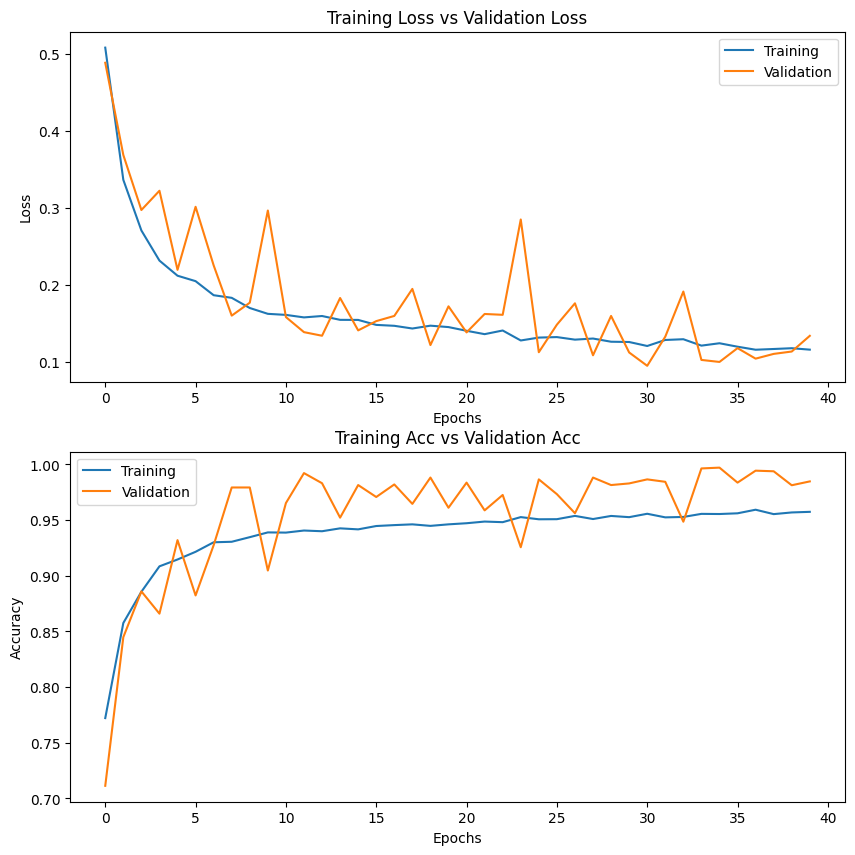

In [113]:
plot_train_val_loss_acc(history_b)

In [114]:
result_b_3 = model_b.evaluate(X_test, y_test)
result_b_3

112/112 [==============================] - 0s 831us/step - loss: 0.2618 - acc: 0.9376


[0.2617828845977783, 0.9375527501106262]

## Convolution, 3 features

### Model

In [115]:
model = models.Sequential()
model.add(layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=X_train.shape[1:]))
model.add(layers.AveragePooling2D(pool_size=2, strides=2))
model.add(layers.Conv2D(filters=16, kernel_size=5, activation='relu'))
model.add(layers.AveragePooling2D(pool_size=2, strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='relu')),
model.add(layers.Dense(84, activation='relu')),
model.add(layers.Dense(10, activation='relu')),
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 6)         456       
                                                                 
 average_pooling2d_8 (Averag  (None, 16, 16, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 average_pooling2d_9 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_6 (Flatten)         (None, 576)               0         
                                                                 
 dense_24 (Dense)            (None, 120)              

In [116]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["acc"])

In [117]:
history = model.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_val, y_val))

Epoch 1/40
344/344 [==============================] - 4s 11ms/step - loss: 0.5198 - acc: 0.7475 - val_loss: 0.6033 - val_acc: 0.7159
Epoch 2/40
344/344 [==============================] - 4s 11ms/step - loss: 0.3284 - acc: 0.8530 - val_loss: 0.2721 - val_acc: 0.9194
Epoch 3/40
344/344 [==============================] - 4s 11ms/step - loss: 0.2433 - acc: 0.8991 - val_loss: 0.2777 - val_acc: 0.9223
Epoch 4/40
344/344 [==============================] - 4s 11ms/step - loss: 0.2024 - acc: 0.9190 - val_loss: 0.1921 - val_acc: 0.9734
Epoch 5/40
344/344 [==============================] - 4s 11ms/step - loss: 0.1811 - acc: 0.9300 - val_loss: 0.1633 - val_acc: 0.9722
Epoch 6/40
344/344 [==============================] - 4s 11ms/step - loss: 0.1681 - acc: 0.9358 - val_loss: 0.2235 - val_acc: 0.9329
Epoch 7/40
344/344 [==============================] - 4s 11ms/step - loss: 0.1635 - acc: 0.9382 - val_loss: 0.2352 - val_acc: 0.9382
Epoch 8/40
344/344 [==============================] - 4s 12ms/step - 

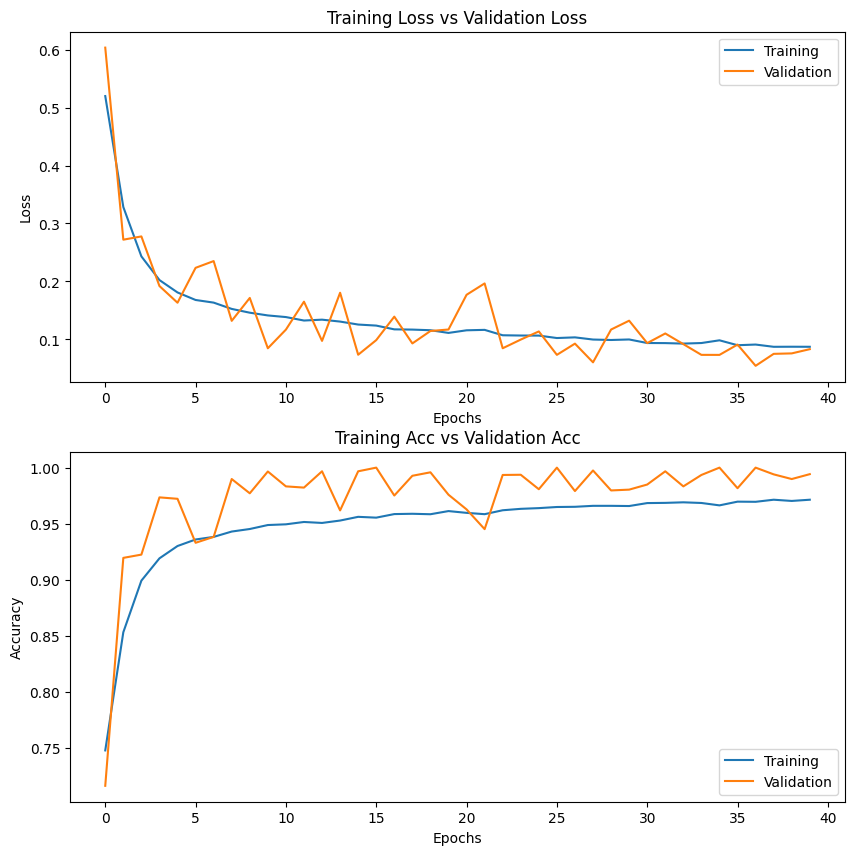

In [118]:
plot_train_val_loss_acc(history)

In [119]:
result_c_3 = model.evaluate(X_test, y_test)
result_c_3

112/112 [==============================] - 0s 2ms/step - loss: 0.3361 - acc: 0.9440


[0.33608847856521606, 0.9440224766731262]

### Result Summary

In [121]:
print('Baseline 1 Feature (CHL):', result_b_1)
print('Convolution 1 Feature (CHL):', result_c_1)
print('Baseline 3 Features:', result_b_3)
print('Convolution 3 Features:', result_c_3)

Baseline 1 Feature (CHL): [0.22234012186527252, 0.9327707290649414]
Convolution 1 Feature (CHL): [0.2222413271665573, 0.9440224766731262]
Baseline 3 Features: [0.2617828845977783, 0.9375527501106262]
Convolution 3 Features: [0.33608847856521606, 0.9440224766731262]
